
# EECS 469/569: Homework 2
## OpenMP
## Single Node Multi-Threaded Performance of Roaring Thunder
### Due: Tuesday, Oct. 4 *before* midnight

### Instructions

This is a partner assignment (you should work together on all sections); as there are an odd number of students there can be exactly one group of three (or one group of one). The results of the homework should be compiled into the Jupyter notebook  called `hw2-submission-groupname.ipynb`, where `groupname` is replaced by your last name(s). The keyword **DELIVERABLE** indicates something that needs to be submitted. There is a checklist of items in the submission notebook. 

All source code, datasets, and plotting code required to run the Jupyter notebook must be included in your submission. All figures should be clear, with axes labeled, including a legend, and a caption. All figures should have a short description and referenced in text in the context of the assignment. All figures should have a short description and referenced in text in the context of the assignment. This assignment will be graded tougher than HW01, make sure you answer **WHY** things happened, not just **WHAT**. 

**Only include files relevant to the assignment in your submission.** A .zip file should be emailed to Dr. Hansen with all code that you wrote for the assignment and datasets to make the plots. A .pdf of the notebook should be submitted to D2L. 

$\mathbf{\infty}$**.1 FIRST DELIVERABLE (-5 points if not on time):** ***By class on Monday, Sep. 19,*** email Dr. Hansen (CC your partner) who you will be working with for this homework. 

### Objectives
1. familiarize the student with OpenMP (Open Multiprocessing);
2. analyze overhead required for OpenMP;
3. apply knowledge of OpenMP to speedup the linear algebra code from Homework 1; and 
4. solve a scientific problem using OpenMP. 

You are required to work on all parts of the assignment with your partner. Do not have one person complete half of the assignment, and vice-versa; this defeats the purpose. 

$\mathbf{\infty}$**.2 FINAL DELIVERABLE:** ***After*** you have completed the entire assignment, write a few paragraphs on your main takeaways from the assignment. **Clearly state** how the work was split up between you and your partner. 

# Procedure

# 1. (Optional) Introduction to OpenMP

**This section is optional,** there are no deliverables or points associated with this section. If you are having issues with OpenMP or C programming, this may be of use to you to get a refresher. 

1. Go to [HPC Training Moodle](https://www.hpc-training.org/xsede/moodle/), create an account, and take the Introduction to OpenMP course. There are many other intro courses that may assist you as we continue with the class.
    1. [It looks like the National Science Foundation has retired XSEDE as of Sept. 1, and replaced it with "Access"](https://www.hpcwire.com/off-the-wire/nsf-announces-upcoming-transition-from-xsede-to-access/). [ACCESS](https://access-ci.org/) as of yet does not have the same nice features as [XSEDE](https://www.xsede.org/), which included HPC tutorials. There may be some issues as these platforms switch over. 



# 2. OpenMP Overhead

The process of forking/joining threads is not free! There is an overhead (in terms of time/CPU cycles) involved in each OpenMP directive and clause. This section will explore the overhead of these different OpenMP constructs using the [Edinburgh Parallel Computing Centre (EPCC) OpenMP MicroBenchmark Suite](https://www.epcc.ed.ac.uk/research/computing/performance-characterisation-and-benchmarking). Specifically, we are using this [Github fork](https://github.com/LangdalP/EPCC-OpenMP-micro-benchmarks).

1. Read the paper "Measuring Synchronisation and Scheduling Overheads in OpenMP" on D2L. 
2. Make sure that you have copied the `syncbench` folder. 
3. Compile and run the `syncbench` microbenchmark using the provided makefile and SLURM file (you may need to do this in a separate command line window, from the syncbench folder). 
```bash
make syncbench schedbench
sbatch hw2_sync.slurm
```
4. Once the batch file has completed, read through the output of the benchmarks.
    * schedbench.csv - comma separated file of the overhead of different OpenMP schedulers. 
    * syncbench.out - human readable printout of the synchronization overhead. 

**2.1 DELIVERABLE:** Write a one paragraph summary of the paper. 



**2.2 DELIVERABLE:** For syncbench: create a table with the average overhead time, and discuss the overhead of the following OpenMP directives: parallel, for, parallel for, barrier, critical, atomic. 

Create a box-whiskers that compares the time distribution between critical, lock/unlock, and atomic. An example is given below.

Text(0, 0.5, 'overhead (us)')

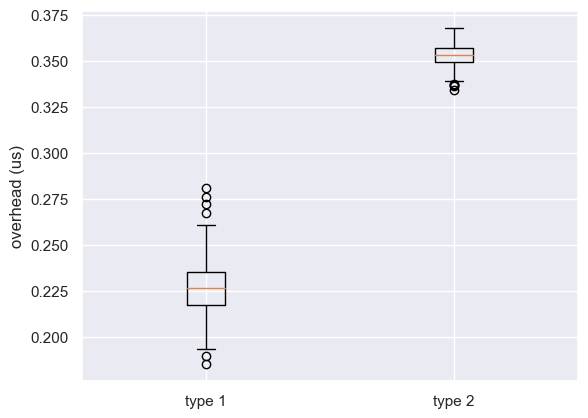

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set()

#get random number generator from numpy
rng = np.random.default_rng()

y1 = rng.normal(0.227,0.013,size=1000)
y2 = rng.normal(0.353,0.006,size=1000)

names = ['type 1','type 2']

plt.boxplot([y1,y2],labels=names)
plt.ylabel('overhead (us)')

**2.3 DELIVERABLE:** For schedbench: load the CSV file output using Python below. Recreate Fig. 7 from the paper, except use the overhead time in microseconds (us) instead of clock cycles. You may need to use a log-scale for the y-axis. 

For the dynamic scheduler overhead, create a single figure that has a normal distribution plotted for each of the different chunk sizes for the overhead time. Make sure the alpha value of the plots allows visualization for overlapping distributions. Two example plots are provided. If you find the values are too disparate, you may select a subset of chunk sizes that make sense. 

Discuss the difference in overhead for the different schedulers. Why would you use one over the other?

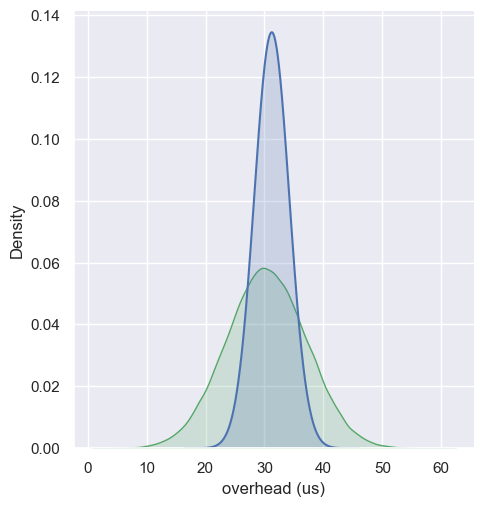

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np
%matplotlib inline

sns.set()

#plot using seaborn KDE
mean2 = 30.24
std2 = 6.88

X2 = np.random.normal(mean2,std2,size=100000)
sns.displot(X2, kind='kde',fill=True,alpha=.2,color='g')


#plot using the exact normal distribution formula
mean = 31.239483
stdev = 2.967858

xmin = mean - 5*stdev
xmax = mean + 5*stdev
step = (xmax - xmin) / 1000

X = np.arange(xmin,xmax,step)

plt.plot(X,norm.pdf(X,mean,stdev))
ax = plt.gca() #get current axes
ax.fill(X,norm.pdf(X,mean,stdev),alpha=0.2)

ax.set_xlabel('overhead (us)')

plt.show()

# 3. OpenMP Linear Algebra

## ⚠️⚠️ **WARNING:** All deliverables must be executed on a node obtained through SLURM for this section ⚠️⚠️

In this section, we will begin to explore the speedup gained through OpenMP parallelism the linear algebra from Homework 1. Start by making copies of the ***WORKING*** Homework 1 code, or you can use Dr. Hansen's code from D2L:
* Matrix-Matrix Multiply Naive: omp_mat_mat_naive.c
* Matrix-Matrix Multiply Blocked: omp_mat_mat_tiled.c
* Matrix-Vector Product: omp_mat_vec.c
* Dot Product: omp_dot.c

Ensure that you have a $t_1$ (sequential time) for each of the four C codes above that uses the same node as you use in the remainder of the homework (e.g., `quickq`). For the blocking code, you can use a block size of 64. 

## 3.1 OpenMP Matrix-Matrix Product

### 3.1.1 Naive Method
1. Add an `omp parallel for` section to your outermost matrix multiplication loop. 
    * Recall that only the outermost loop variable is made private
    * Ensure thread safety of your result matrix $\mathbf{C}$
    * While testing, you may use the head node of the cluster as long as you use a small matrix size $N$ and number of threads $T$
    * To ensure your code is correct, compare the output to a known $C_{i,j}$ from Homework 1 (with a fixed random number seed)
2. Add another column to your CSV file output that records the number of threads.
3. Using a dedicated SLURM node (`--nodes=1`, `--ntasks-per-node=32`, `--partition=quickq`), run and time the matrix-matrix product using a matrix size of $N=4096$ and different numbers of threads $T = {2,4,8,16,32}$. Run each thread size for at least five runs to obtain an average performance. 
    * HINT: you may want to write a Bash for-loop in your SLURM file that sets the number of threads and then runs the program. 


### 3.1.2 Tiled Method

1. Add an `omp parallel for` section to the outermost *inner loop*. Be careful with multiple memory writes to the C matrix from parallel threads (ensure thread safety via the order of the loops and the placement of the parallel for section). 
2. Repeat step 3 from above using a fixed block size of 64.

**3.1 DELIVERABLE:** 

Create four figures that have $T$ on the x-axis (including $T=1$), and on the y-axis:
1. average parallel speedup versus the sequential time (plot the ideal speedup on the same graph)
2. average floating point operations per second (FLOPs)
3. average execution time
4. average parallel efficiency (plot a line showing perfect parallel efficiency)

Each figure should have two plots: one for the naive method and one for the tiled method. The two plots should have distinct colors and lines (e.g., solid verus dashed). Add a legend that clearly identifies which plot is which. 

***USE AN APPROPRIATE SI PREFIX FOR YOUR Y-AXES (e.g., GFlops)!*** Discuss in one paragraph per figure the impact of OpenMP and the number of threads on algorithm performance. ***WHY*** do you think you are seeing the results you are? Not just **WHAT**.

### 3.1.3 Matrix Multiplication via Tasks
1. Start with the `matrix_multiply_omp_tasks.c` code from Dr. Hansen. You should notice that this implementation uses stack memory instead of heap memory. 
2. Read slides 20-30 from `openmptasking.pdf`. Add the OpenMP task directives to the tiled matrix multiplication. Verify you still obtain the correct results.
3. For $N=4096$, $T=32$, and a block size of 64, obtain 20 results for both the task based matrix multiply and the parallel for based matrix multiply (tiled versions). 

#### 3.2 DELIVERABLE:
Create a box and whiskers plot that compares the FLOPs performance of the tasking based parallelism versus the for-loop based parallelism. Write one paragraph that discusses the results. 

## 3.2 Comparison of Different Linear Algebra Algorithms

In the prior section we explored matrix-matrix multiply, which is an $N^3$ algorithm on $N^2$ data. In this section, you will explore the scalability of the dot product ($N$ operations on $N$ data) and the matrix-vector product ($N^2$ operations on $N^2$ data). 

1. Add appropriate `parallel for` directives to your matrix-vector product and dot product code. Ensure that you still get the same answer as your sequential version. 
2. Using a dedicated SLURM node (`--nodes=1`, `--ntasks-per-node=32`, `--partition=quickq`), run and time the matrix-vector product using size of $N=32,768$ ($2^{15}$) and the dot product for $N=1,073,741,824$ ($2^{30}$) and different numbers of threads $T = {1,2,4,8,16,32}$. Run each thread size for at least five runs to obtain an average performance. 
    * Run $T=32$ for 20 outputs. 

**3.3 DELIVERABLE:** 

Create two figures that have $T$ on the x-axis (including $T=1$), and on the y-axis:
1. average parallel speedup versus the sequential time (plot the ideal speedup on the same graph)
2. average floating point operations per second (FLOPs)

Each figure should have two plots: one for the dot product and one for the matrix-vector product. The two plots should have distinct colors and lines (e.g., solid verus dashed). Add a legend that clearly identifies which plot is which. 

Create a box-whiskers plot that shows the FLOPs performance compared between the matrix-matrix product (all three versions), matrix-vector product, and dot-product. Discuss the results.

# 4. Non-Linear-Algebra

Use OpenMP (`--nodes=1`, `--ntasks-per-node=32`, `--partition=quickq`) to accelerate the solution to one of the following computer science/engineering problems from [John Burkhardt at Florida State University](https://people.sc.fsu.edu/~jburkardt/):

* [2D steady state heated plate](https://people.sc.fsu.edu/~jburkardt/c_src/heated_plate/heated_plate.html)
* [Molecular Dynamics](https://people.sc.fsu.edu/~jburkardt/c_src/md/md.html)
* [Quadrature Rule Integration](https://people.sc.fsu.edu/~jburkardt/c_src/quad/quad.html)
* [Poisson Equation](https://people.sc.fsu.edu/~jburkardt/c_src/poisson/poisson.html)
* [Integer Search](https://people.sc.fsu.edu/~jburkardt/c_src/search/search.html)
* [Forest Fire Simulation](https://people.sc.fsu.edu/~jburkardt/c_src/fire_simulation/fire_simulation.html)
* [Fast Fourier Transform](https://people.sc.fsu.edu/~jburkardt/c_src/fft_serial/fft_serial.html)
* [Prime Numer Search](https://people.sc.fsu.edu/~jburkardt/c_src/prime/prime.html)


If there is another problem you would prefer to solve, such as any from the [C code repository](https://people.sc.fsu.edu/~jburkardt/c_src/c_src.html) just ask. 

You need to prove to me via a data output that the problem works correctly after parallelization with OpenMP. Depending on which problem you chose, your method to showcase your results will be different. At minimum you need to show the parallel speedup obtained between $T=1$ and $T=32$. 

***NOTE:*** I am aware that each of these has an OpenMP solution that is available online. That is not the purpose of this exercise. If you need hints, take a look, but you really should try to solve it on your own as best as you can. 



**4.1 DELIVERABLE:** Describe what problem you chose and how you accelerated it using OpenMP. Prove that the parallel version is thread safe (same answer as non-threaded) and show the parallel speedup. 

Discuss your problem with another group and describe their problem in a few sentences, and which group (by name of team members). 